In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [ ]:
#PARAMS
OUTPUT_SEQUENCE_LENGTH = 50
EMBEDDING_DIMENSION = 50
ALPHA = 0
BATCH_SIZE = 512

#Installing the Libraries

In [ ]:
!pip install transformers
!pip install spacy
!pip install tensorflow

In [ ]:
!pip install datasets

In [ ]:
!spacy download en_core_web_sm

#Importing and mounting the drive 

In [ ]:
import re
import spacy
import numpy as np
import pandas as pd
import en_core_web_sm
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import Sequence

from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from datasets import load_from_disk, Dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Loading the dataset

In [ ]:
mrpc = load_from_disk("/content/drive/MyDrive/CS685/project/datasets/MRPC")

# Creating Embeddings and Padded sequences of the data

In [ ]:
sentences = mrpc['train']['sentence1']+mrpc['train']['sentence2']
combined_logits = mrpc['train']['combined_logits']
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=OUTPUT_SEQUENCE_LENGTH)
text_ds = tf.data.Dataset.from_tensor_slices(sentences).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
import os
path_to_glove_file = "/content/drive/MyDrive/CS685/project/glove.6B.50d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 12238 words (1354 misses)


#Embeddings layer

In [ ]:
import torch
cur_batch_size = 128
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
)

embedding_layer
sentences

> Indented block

> [Indented block](https:// [link text](https://))





In [ ]:
cur_batch_size = BATCH_SIZE

# Define a function to preprocess a single batch of data
def preprocess_batch(batch_data):
  sentences1, sentences2, combined_logits = batch_data['sentence1'], batch_data['sentence2'], batch_data['combined_logits']
  
  sentences1_data = tf.convert_to_tensor(embedding_layer(vectorizer(sentences1)).numpy())
  sentences2_data = tf.convert_to_tensor(embedding_layer(vectorizer(sentences2)).numpy())

  padded_sequences = tf.concat((sentences1_data, sentences2_data, sentences1_data*sentences2_data, tf.math.abs(sentences1_data - sentences2_data)), axis=1)
  combined_logits = np.array(combined_logits)
  return padded_sequences, combined_logits

padded_sequences, labels = preprocess_batch(mrpc['train'])

In [ ]:
from tqdm.notebook import tqdm

#Custom Loss and Custom accuracy metric
Iterating on alpha to find the best alpha

In [ ]:
# alpha = ALPHA
class TotalLoss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    # print(y_true)
    true_labels, teacher_logits= tf.split(y_true, num_or_size_splits=2, axis=1)
    # print(teacher_logits.shape, teacher_logits.shape)
    teacher_logits = teacher_logits[:, 0]
    # print(teacher_logits.shape, teacher_logits.shape)
    loss_wrt_teacher = tf.math.reduce_mean(tf.square(teacher_logits - y_pred))
    loss_wrt_true = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels, logits=y_pred))
    # print("loss_wrt_teacher", loss_wrt_teacher,"loss_wrt_true", loss_wrt_true)
    return alpha*loss_wrt_true+(1-alpha)*loss_wrt_teacher

class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        self.total_correct = self.add_weight(name='total_correct', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
      true_labels, teacher_logits= tf.split(y_true, num_or_size_splits=2, axis=1)
      y_pred = tf.argmax(y_pred, axis=-1)
      y_true = tf.argmax(true_labels, axis=-1)
      y_true = tf.squeeze(y_true)
      cur_correct = tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.float32))
      cur_smaples = tf.cast(tf.size(y_pred), tf.float32)
      # print("cur_correct", cur_correct, "cur_smaples", cur_smaples)
      
      self.total_correct.assign_add(cur_correct)
      self.total_samples.assign_add(cur_smaples)
    
    def result(self):
        return self.total_correct / self.total_samples
    
    def reset_state(self):
        self.total_correct.assign(0.0)
        self.total_samples.assign(0.0)

for alpha in tqdm([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):
  try:
    del model
  except Exception as e:
    print('No Model')

  
  model = Sequential()
  model.add(Bidirectional(LSTM(300, return_sequences=False), input_shape=(200, 50)))  #Check what does input shape mean #Remove this 50 X 300(glove) & 50X64 
  model.add(Dropout(0.2)) # Avoid Overfitting
  model.add(Dense(400, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2)) #OutputClasses
  # optimizer = Adam(learning_rate=0.01)
  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-07)
  model.compile(
      loss=TotalLoss(), 
      optimizer=optimizer, 
      metrics=[CustomAccuracy()],
      run_eagerly = True
  )
  model.build(input_shape=(cur_batch_size, 200, 300))
  model.summary()


  history = model.fit(
      padded_sequences,
      labels,
      epochs=5,
      verbose=1,
      batch_size=cur_batch_size,
      validation_split=0.1
  )

  print('alpha', alpha)
  print(history.history['val_accuracy'])
  print(history.history['accuracy'])

  0%|          | 0/6 [00:00<?, ?it/s]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 600)              842400    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 600)               0         
                                                                 
 dense_4 (Dense)             (None, 400)               240400    
                                                                 
 dropout_4 (Dropout)         (None, 400)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 802       
                                                                 
Total params: 1,083,602
Trainable params: 1,083,602
Non-trainable params: 0
____________________________________________

#Plots graph

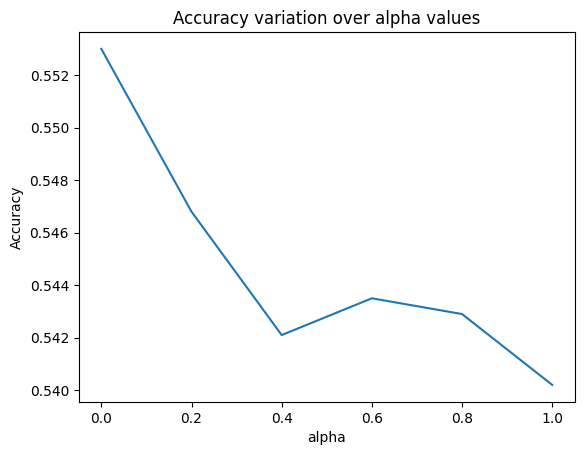

In [4]:
import matplotlib.pyplot as plt
x = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
y = [0.5530, 0.5468, 0.5421, 0.5435, 0.5429, 0.5402] #experiment results
fig = plt.plot(x, y)
title = plt.title("Accuracy variation over alpha values")
xlabel = plt.xlabel("alpha")
ylabel = plt.ylabel("Accuracy")

# Training the model with best alpha found

In [ ]:
alpha = 0.2 # Best Value

try:
    del model
except Exception as e:
  print('No Model')

model = Sequential()
model.add(Bidirectional(LSTM(300, return_sequences=False), input_shape=(4*OUTPUT_SEQUENCE_LENGTH, EMBEDDING_DIMENSION)))  #Check what does input shape mean #Remove this 50 X 300(glove) & 50X64 
model.add(Dropout(0.2)) # Avoid Overfitting
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2)) #OutputClasses
# optimizer = Adam(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-07)
model.compile(
    loss=TotalLoss(), 
    optimizer=optimizer, 
    metrics=[CustomAccuracy()],
    run_eagerly = True
)
model.build(input_shape=(cur_batch_size, 4*OUTPUT_SEQUENCE_LENGTH, EMBEDDING_DIMENSION))
model.summary()


history = model.fit(
    padded_sequences,
    labels,
    epochs=50,
    verbose=1,
    batch_size=cur_batch_size,
    validation_split=0.1
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 600)              842400    
 nal)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 600)               0         
                                                                 
 dense_16 (Dense)            (None, 400)               240400    
                                                                 
 dropout_16 (Dropout)        (None, 400)               0         
                                                                 
 dense_17 (Dense)            (None, 2)                 802       
                                                                 
Total params: 1,083,602
Trainable params: 1,083,602
Non-trainable params: 0
____________________________________________

KeyboardInterrupt: ignored

#Plot learning curve

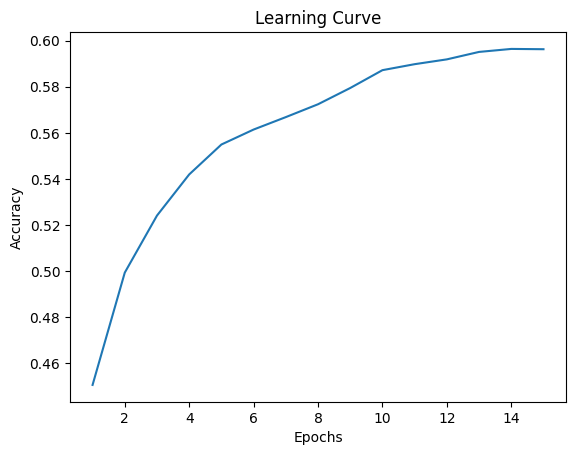

In [5]:
import matplotlib.pyplot as plt
x = [i for i in range(1, 16, 1)]
y = [0.4506124258041382, 0.4993506669998169, 0.524101734161377, 0.5419520735740662, 0.5549387335777283, 0.5614321231842041, 0.5668304562568665, 0.5724071264266968, 0.5794606804847717, 0.5872017741203308, 0.5897991061210632, 0.5918871164321899, 0.5951210856437683, 0.5964197516441345, 0.5962924361228943]

fig = plt.plot(x, y)
title = plt.title("Learning Curve")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Accuracy")

#Computing the metrics

In [ ]:
def get_test_data(data):
  sentences1, sentences2, labels = data['sentence1'], data['sentence2'], data['label']
  
  sentences1_data = tf.convert_to_tensor(embedding_layer(vectorizer(sentences1)).numpy())
  sentences2_data = tf.convert_to_tensor(embedding_layer(vectorizer(sentences2)).numpy())

  padded_sequences = tf.concat((sentences1_data, sentences2_data, sentences1_data*sentences2_data, tf.math.abs(sentences1_data - sentences2_data)), axis=1)
  labels = np.array(labels)
  return padded_sequences, labels
#Code for f1 score, accuracy and confusion matrix

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

test_padded_sequences, true_lables = get_test_data(mrpc['validation'])

predictions = model.predict(test_padded_sequences)
class_labels = np.argmax(predictions, axis=-1)

cm = confusion_matrix(true_lables, class_labels)
f1 = f1_score(true_lables, class_labels)
accuracy = accuracy_score(true_lables, class_labels)

print("Confusion Matrix: \n", cm)
print("F1 Score:", f1)
print('Accuracy:', accuracy)

In [ ]:
flag = np.array(class_labels == true_lables)
missed_values = []
identified_values = []
for i, f in enumerate(flag):
  if f:
    identified_values.append((mrpc['validation'][i]['sentence1'], mrpc['validation'][i]['sentence2'], mrpc['validation'][i]['label']))

for i, f in enumerate(flag):
  if not f:
    missed_values.append((mrpc['validation'][i]['sentence1'], mrpc['validation'][i]['sentence2'], mrpc['validation'][i]['label']))

In [ ]:
identified_values[:10]

[("He said the foodservice pie business doesn 't fit the company 's long-term growth strategy .",
  '" The foodservice pie business does not fit our long-term growth strategy .'),
 ('The AFL-CIO is waiting until October to decide if it will endorse a candidate .',
  'The AFL-CIO announced Wednesday that it will decide in October whether to endorse a candidate before the primaries .'),
 ('Wal-Mart said it would check all of its million-plus domestic workers to ensure they were legally employed .',
  'It has also said it would review all of its domestic employees more than 1 million to ensure they have legal status .'),
 ('This integrates with Rational PurifyPlus and allows developers to work in supported versions of Java , Visual C # and Visual Basic .NET.',
  'IBM said the Rational products were also integrated with Rational PurifyPlus , which allows developers to work in Java , Visual C # and VisualBasic .Net.'),
 ('The top rate will go to 4.45 percent for all residents with taxable i

#Failed cases

In [ ]:
missed_values
# 1 - paraphrased, 0 - not paraphrased

[('Magnarelli said Racicot hated the Iraqi regime and looked forward to using his long years of training in the war .',
  'His wife said he was " 100 percent behind George Bush " and looked forward to using his years of training in the war .',
  0),
 ('The dollar was at 116.92 yen against the yen , flat on the session , and at 1.2891 against the Swiss franc , also flat .',
  'The dollar was at 116.78 yen JPY = , virtually flat on the session , and at 1.2871 against the Swiss franc CHF = , down 0.1 percent .',
  0),
 ('No dates have been set for the civil or the criminal trial .',
  'No dates have been set for the criminal or civil cases , but Shanley has pleaded not guilty .',
  0),
 ('While dioxin levels in the environment were up last year , they have dropped by 75 percent since the 1970s , said Caswell .',
  'The Institute said dioxin levels in the environment have fallen by as much as 76 percent since the 1970s .',
  0),
 ('" Sanitation is poor ... there could be typhoid and choler